In [1]:
import pandas as pd
import numpy as np
import json
import trimesh
import matplotlib.pyplot as plt
import pyglet
from pyglet.gl import *
import pyvista as pv
from mpl_toolkits.mplot3d import Axes3D
import ast
import mne
from sklearn.cluster import KMeans
from itertools import cycle

In [2]:
in_df = pd.read_parquet(
    "/Users/siyuanzhao/Documents/DATADIR/patients/ep129/sample1/eegdb.parquet",
    engine="pyarrow",
)

electrodes = (
    26,
    28,
    36,
    20,
    32,
    21,
    22,
    40,
    41,
    54,
    19,
    31,
    39,
    47,
    48,
    52,
    56,
    27,
    29,
    34,
    35,
    43,
    49,
    50,
    53,
    18,
    33,
    44,
    30,
    38,
    51,
    37,
    108,
    109,
    107,
    102,
    112,
    55,
    45,
    23,
    103,
    73,
    74,
    76,
    75,
    84,
    89,
)
eeg_data_df_filtered = in_df[
    (in_df["electrode"].isin(electrodes)) & (in_df["ms"] >= 0) & (in_df["ms"] <= 500)
]
output = {}
for electode in electrodes:
    output[electode] = eeg_data_df_filtered.loc[
        eeg_data_df_filtered.electrode == electode
    ].value.values.tolist()

with open("ep129_sample1_0_500_egg.json", "w") as f:
    json.dump(output, f)

KeyboardInterrupt: 

In [ ]:
in_df = pd.read_parquet(
    "/Users/siyuanzhao/Documents/DATADIR/patients/ep187/sample1/eegdb.parquet",
    engine="pyarrow",
)

electrodes = (95,60,61,59,72,70,79,71,78,87,58,63,62)
eeg_data_df_filtered = in_df[
    (in_df["electrode"].isin(electrodes))
    & (in_df["ms"] >= 14000)
    & (in_df["ms"] <= 14500)
]
output = {}
for electode in electrodes:
    output[electode] = eeg_data_df_filtered.loc[
        eeg_data_df_filtered.electrode == electode
    ].value.values.tolist()

with open('ep187_sample1_14000_14500_egg.json', 'w') as f:
    json.dump(output, f)

In [ ]:
# ep129 event 1

propogation_df = pd.read_json(
    "/Users/siyuanzhao/Documents/DATADIR/patients/ep129/sample1/ep129_sorted_data.json"
)
propogation_test_df = propogation_df[propogation_df["eventIndex"] == 1]
# save ep129, sample1, event 1 electrode propagation json to local
propogation_test_df.to_json("ep129_sample1_electrode_event1.json", index=False)

In [ ]:
# ep187 event 45

propogation_df = pd.read_json(
    "/Users/siyuanzhao/Documents/DATADIR/patients/ep187/sample1/ep187_sorted_data.json"
)
propogation_test_df = propogation_df[propogation_df["eventIndex"] == 45]
# save ep187, sample1, event 45 electrode propagation json to local
propogation_test_df.to_json("ep187_sample1_electrode_event45.json", index=False)

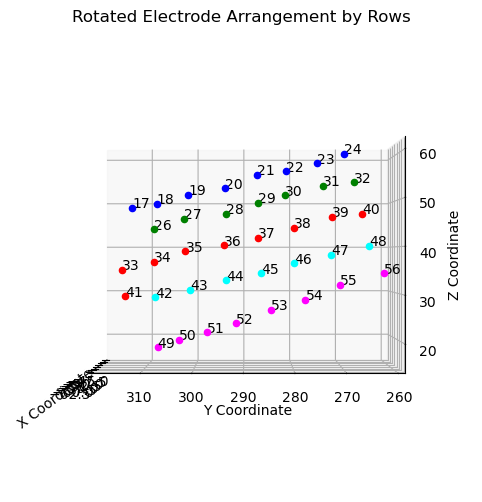

In [183]:
# ep129 roi 2

# Load your data
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/ep129_electrodes_relative.csv")
electrode_roi_df = pd.read_json("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/sample1/ep129_sample1_full_network.json")

# Create a dictionary to map electrode numbers to positions
electrode_position_map = dict(zip(electrode_df["electrode_number"], electrode_df["position"].apply(ast.literal_eval)))

# Filter electrodes based on ROI and get their positions
roi2_arr = []
electrode_roi_2_df = electrode_roi_df[electrode_roi_df["roi"] == 2]
for item in electrode_roi_2_df["electrodes"].iloc[0]:  # Assuming electrode numbers are in the first row
    if item in electrode_position_map:
        # print(electrode_position_map[item], '?????')
        roi2_arr.append(electrode_position_map[item])


# Rotate the positions
theta = 18
positions = np.array(roi2_arr)
rotated_positions = np.dot(positions, rotation_matrix_x(theta).T)

# Sort rotated positions and find corresponding electrode numbers
z_threshold = 2
rows_electrode_numbers = []
current_row_electrode_numbers = []
last_z = rotated_positions[0, 2]

for position in rotated_positions:
    # Check the electrode number for each rotated position
    electrode_number = next((num for num, pos in electrode_position_map.items() if np.allclose(pos[0], position[0])), None)
    if abs(position[2] - last_z) > z_threshold:
        rows_electrode_numbers.append(current_row_electrode_numbers)
        current_row_electrode_numbers = []  
    if electrode_number is not None:
        current_row_electrode_numbers.append(electrode_number)
    last_z = position[2]
    
rows_electrode_numbers.append(current_row_electrode_numbers)

# Save the rows of electrode numbers to a JSON file
with open('roi2_electrodes.json', 'w') as f:
    json.dump(rows_electrode_numbers, f)

# Visualizing the result
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
color_cycle = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow'])

# Plot each point in rows
for row_index, row in enumerate(rows_electrode_numbers):
    current_color = next(color_cycle)
    for col_index, electrode_number in enumerate(row):
        # Find the position of this electrode number
        position = electrode_position_map[electrode_number]
        # Plot the electrode
        ax.scatter(*position, color=current_color)
        # Annotate the plot with the electrode number
        ax.text(*position, f'{electrode_number}')
        

ax.view_init(elev=0, azim=180)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('Rotated Electrode Arrangement by Rows')
plt.show()


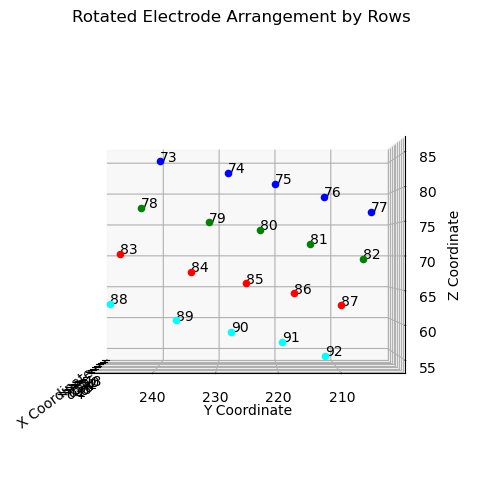

In [179]:
# ep129 roi 0

# Load your data
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/ep129_electrodes_relative.csv")
electrode_roi_df = pd.read_json("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/sample1/ep129_sample1_full_network.json")

# Create a dictionary to map electrode numbers to positions
electrode_position_map = dict(zip(electrode_df["electrode_number"], electrode_df["position"].apply(ast.literal_eval)))

# Filter electrodes based on ROI and get their positions
roi2_arr = []
electrode_roi_2_df = electrode_roi_df[electrode_roi_df["roi"] == 0]
for item in electrode_roi_2_df["electrodes"].iloc[0]:  # Assuming electrode numbers are in the first row
    if item in electrode_position_map:
        # print(electrode_position_map[item], '?????')
        roi2_arr.append(electrode_position_map[item])


# Rotate the positions
theta = -10
positions = np.array(roi2_arr)
rotated_positions = np.dot(positions, rotation_matrix_x(theta).T)

# Sort rotated positions and find corresponding electrode numbers
z_threshold = 2
rows_electrode_numbers = []
current_row_electrode_numbers = []
last_z = rotated_positions[0, 2]

for position in rotated_positions:
    # Check the electrode number for each rotated position
    electrode_number = next((num for num, pos in electrode_position_map.items() if np.allclose(pos[0], position[0])), None)
    if abs(position[2] - last_z) > z_threshold:
        rows_electrode_numbers.append(current_row_electrode_numbers)
        current_row_electrode_numbers = []  
    if electrode_number is not None:
        current_row_electrode_numbers.append(electrode_number)
    last_z = position[2]
    
rows_electrode_numbers.append(current_row_electrode_numbers)

# Save the rows of electrode numbers to a JSON file
with open('roi0_electrodes.json', 'w') as f:
    json.dump(rows_electrode_numbers, f)

# Visualizing the result
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
color_cycle = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow'])

# Plot each point in rows
for row_index, row in enumerate(rows_electrode_numbers):
    current_color = next(color_cycle)
    for col_index, electrode_number in enumerate(row):
        # Find the position of this electrode number
        position = electrode_position_map[electrode_number]
        # Plot the electrode
        ax.scatter(*position, color=current_color)
        # Annotate the plot with the electrode number
        ax.text(*position, f'{electrode_number}')
        

ax.view_init(elev=0, azim=180)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('Rotated Electrode Arrangement by Rows')
plt.show()


In [30]:
# ep129 roi 1

electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/ep129_electrodes_relative.csv")
electrode_roi_df = pd.read_json("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/sample1/ep129_sample1_full_network.json")
roi2_arr = []
electrode_roi_2_df = electrode_roi_df[electrode_roi_df["roi"] == 1]
electrode_filtered_2_df = electrode_roi_2_df["electrodes"]
electrode_df["electrode_number"]
for item in electrode_filtered_2_df[1]:
    for ele in electrode_df["electrode_number"]:
       if item == ele:
           selected_ele = electrode_df[electrode_df["electrode_number"] == ele]["position"].values[0]
           roi2_arr.append(selected_ele)


converted_roi2_arr = [ast.literal_eval(item) if isinstance(item, str) else item for item in roi2_arr]

positions = np.array(converted_roi2_arr)

# Sort positions by y-coordinate to separate rows
positions_sorted_by_y = positions[np.argsort(positions[:, 1])]

# Group electrodes into rows and sort each row by x-coordinate
sorted_positions = []
current_row = []
last_y = positions_sorted_by_y[0][1]

for position in positions_sorted_by_y:
    if position[1] != last_y:
        # Sort the current row by x-coordinate and add to sorted_positions
        sorted_positions.append(np.array(sorted(current_row, key=lambda x: x[0])))
        current_row = []
    current_row.append(position)
    last_y = position[1]

# Don't forget to add the last row
sorted_positions.append(np.array(sorted(current_row, key=lambda x: x[0])))

# Visualizing the result
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
color_cycle = cycle(['blue', 'green', 'red', 'cyan', 'magenta'])

# Plot each point and label it with row and column index
for row_index, row in enumerate(sorted_positions):
    current_color = next(color_cycle)
    for col_index, position in enumerate(row):
        ax.scatter(*position, color=current_color)
        ax.text(*position, f'{row_index+1},{col_index+1}')
# ax.view_init(elev=0, azim=180)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('Electrode Row and Column Arrangement')
plt.show()


0      17
1      18
2      19
3      20
4      21
     ... 
74    108
75    109
76    110
77    111
78    112
Name: electrode_number, Length: 79, dtype: int64

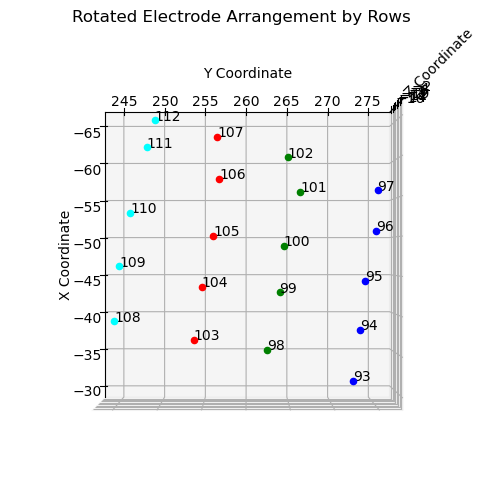

In [27]:
# Load your data
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/ep129_electrodes_relative.csv")
electrode_roi_df = pd.read_json("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/sample1/ep129_sample1_full_network.json")

# Create a dictionary to map electrode numbers to positions
electrode_position_map = dict(zip(electrode_df["electrode_number"], electrode_df["position"].apply(ast.literal_eval)))

# Filter electrodes based on ROI and get their positions
roi2_arr = []
electrode_roi_2_df = electrode_roi_df[electrode_roi_df["roi"] == 1]
for item in electrode_roi_2_df["electrodes"].iloc[0]:  # Assuming electrode numbers are in the first row
    if item in electrode_position_map:
        # print(electrode_position_map[item], '?????')
        roi2_arr.append(electrode_position_map[item])

def rotation_matrix_x(theta):
    cos_theta, sin_theta = np.cos(np.radians(theta)), np.sin(np.radians(theta))
    return np.array([[1, 0, 0],
                     [0, cos_theta, -sin_theta],
                     [0, sin_theta, cos_theta]])

# Rotate the positions
theta = 90
positions = np.array(roi2_arr)
rotated_positions = np.dot(positions, rotation_matrix_x(theta).T)

# Sort rotated positions and find corresponding electrode numbers
z_threshold = 2
rows_electrode_numbers = []
current_row_electrode_numbers = []
last_z = rotated_positions[0, 2]

for position in rotated_positions:
    # Check the electrode number for each rotated position
    electrode_number = next((num for num, pos in electrode_position_map.items() if np.allclose(pos[0], position[0])), None)
    if abs(position[2] - last_z) > z_threshold:
        rows_electrode_numbers.append(current_row_electrode_numbers)
        current_row_electrode_numbers = []  
    if electrode_number is not None:
        current_row_electrode_numbers.append(electrode_number)
    last_z = position[2]
    
rows_electrode_numbers.append(current_row_electrode_numbers)

# Save the rows of electrode numbers to a JSON file
with open('roi1_electrodes.json', 'w') as f:
    json.dump(rows_electrode_numbers, f)

# Visualizing the result
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
color_cycle = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow'])

# Plot each point in rows
for row_index, row in enumerate(rows_electrode_numbers):
    current_color = next(color_cycle)
    for col_index, electrode_number in enumerate(row):
        # Find the position of this electrode number
        position = electrode_position_map[electrode_number]
        # Plot the electrode
        ax.scatter(*position, color=current_color)
        # Annotate the plot with the electrode number
        ax.text(*position, f'{electrode_number}')
        

ax.view_init(elev=90, azim=0)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('Rotated Electrode Arrangement by Rows')
plt.show()


In [17]:
propagation_df = pd.read_json("/Users/siyuanzhao/Downloads/sample1_events.json")

electrode_counts = {}

for network_list in propagation_df['network']:
    if(network_list):
        for item in network_list:
            source = item['source']
            target = item['target']

            # Increment source count
            if source in electrode_counts:
                electrode_counts[source]['source_counts'] += 1
            else:
                electrode_counts[source] = {'electrode_id': source, 'source_counts': 1, 'target_counts': 0}

            # Increment target count
            if target in electrode_counts:
                electrode_counts[target]['target_counts'] += 1
            else:
                electrode_counts[target] = {'electrode_id': target, 'source_counts': 0, 'target_counts': 1}

# Convert 
result = list(electrode_counts.values())

print(result)

output_file = 'ep129_sample1_propagation_new.json'
with open(output_file, 'w') as file:
    json.dump(result, file, indent=4)


[{'electrode_id': 26, 'source_counts': 1512, 'target_counts': 668}, {'electrode_id': 18, 'source_counts': 185, 'target_counts': 373}, {'electrode_id': 27, 'source_counts': 1843, 'target_counts': 979}, {'electrode_id': 28, 'source_counts': 1286, 'target_counts': 1057}, {'electrode_id': 32, 'source_counts': 379, 'target_counts': 507}, {'electrode_id': 34, 'source_counts': 1183, 'target_counts': 414}, {'electrode_id': 35, 'source_counts': 1669, 'target_counts': 772}, {'electrode_id': 36, 'source_counts': 800, 'target_counts': 1146}, {'electrode_id': 43, 'source_counts': 985, 'target_counts': 302}, {'electrode_id': 44, 'source_counts': 1062, 'target_counts': 483}, {'electrode_id': 19, 'source_counts': 316, 'target_counts': 463}, {'electrode_id': 107, 'source_counts': 476, 'target_counts': 510}, {'electrode_id': 108, 'source_counts': 686, 'target_counts': 631}, {'electrode_id': 20, 'source_counts': 1035, 'target_counts': 1086}, {'electrode_id': 21, 'source_counts': 903, 'target_counts': 957

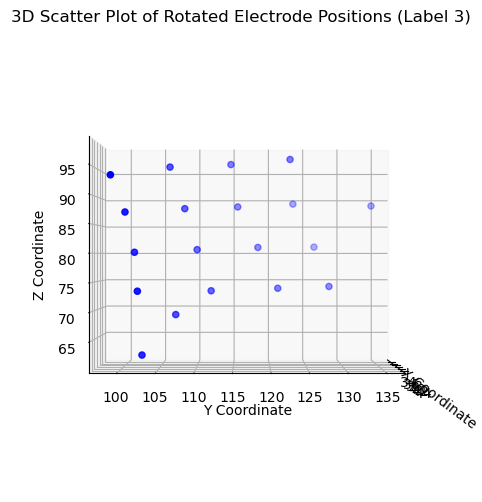

In [61]:

# Load your data
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep187/ep187_rois_kmeans.csv")

# Create a dictionary to map electrode numbers to positions
electrode_position_map = dict(zip(electrode_df["electrode_number"], electrode_df["position"].apply(ast.literal_eval)))

# Filter electrodes based on the label (e.g., label==3) and get their positions
label_value = 1
label_filtered_arr = []
electrode_label_filtered_df = electrode_df[electrode_df["label"] == label_value]
for index, row in electrode_label_filtered_df.iterrows():
    electrode_number = row["electrode_number"]
    if electrode_number in electrode_position_map:
        label_filtered_arr.append(electrode_position_map[electrode_number])

# Rotate the positions (you can reuse your existing rotation code here)
theta = -20
positions = np.array(label_filtered_arr)
rotated_positions = np.dot(positions, rotation_matrix_x(theta).T)

# Create a 3D scatter plot for the rotated positions
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rotated_positions[:, 0], rotated_positions[:, 1], rotated_positions[:, 2], c='blue', marker='o')

ax.view_init(elev=0, azim=0)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
ax.set_title('3D Scatter Plot of Rotated Electrode Positions (Label 3)')
plt.grid()
plt.show()


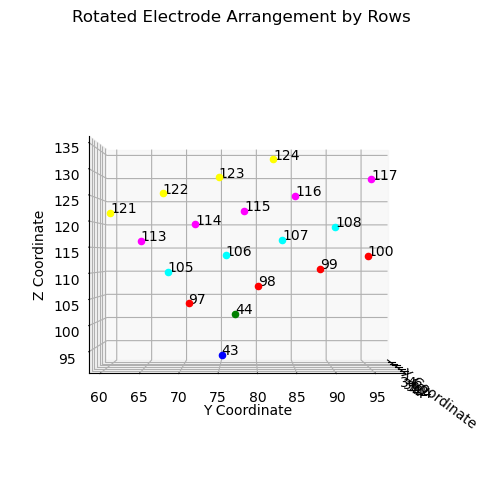

[[43], [44], [97, 98, 99, 100], [105, 106, 107, 108], [113, 114, 115, 116, 117], [121, 122, 123, 124]]


In [92]:
# ep187 sample1 lable1
# Load your data
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep187/ep187_rois_kmeans.csv")

# Create a dictionary to map electrode numbers to positions
electrode_position_map = dict(zip(electrode_df["electrode_number"], electrode_df["position"].apply(ast.literal_eval)))

# Filter electrodes based on the label (e.g., label==3) and get their positions
label_value = 1
label_filtered_arr = []
electrode_label_filtered_df = electrode_df[electrode_df["label"] == label_value]
for index, row in electrode_label_filtered_df.iterrows():
    electrode_number = row["electrode_number"]
    if electrode_number in electrode_position_map:
        label_filtered_arr.append(electrode_position_map[electrode_number])

# Rotate the positions
theta = -20
positions = np.array(label_filtered_arr)
rotated_positions = np.dot(positions, rotation_matrix_x(theta).T)

# Sort rotated positions and find corresponding electrode numbers
z_threshold = 4
rows_electrode_numbers = []
current_row_electrode_numbers = []
last_z = rotated_positions[0, 2]

for position in rotated_positions:
    # Check the electrode number for each rotated position
    electrode_number = next((num for num, pos in electrode_position_map.items() if np.allclose(pos[0], position[0])), None)
    if abs(position[2] - last_z) > z_threshold:
        rows_electrode_numbers.append(current_row_electrode_numbers)
        current_row_electrode_numbers = []  
    if electrode_number is not None:
        current_row_electrode_numbers.append(electrode_number)
    last_z = position[2]

rows_electrode_numbers.append(current_row_electrode_numbers)

# Export the result as a list of lists
result_list = [row for row in rows_electrode_numbers]

# Visualizing the result
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
color_cycle = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow'])

# Plot each point in rows
for row_index, row in enumerate(rows_electrode_numbers):
    current_color = next(color_cycle)
    for col_index, electrode_number in enumerate(row):
        # Find the position of this electrode number
        position = electrode_position_map[electrode_number]
        # Plot the electrode
        ax.scatter(*position, color=current_color)
        # Annotate the plot with the electrode number
        ax.text(*position, f'{electrode_number}')
        
ax.view_init(elev=0, azim=0)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('Rotated Electrode Arrangement by Rows')
plt.show()

# Export the result as a JSON file
# with open('exported_result.json', 'w') as f:
#     json.dump(result_list, f)

# Print the result
print(result_list)



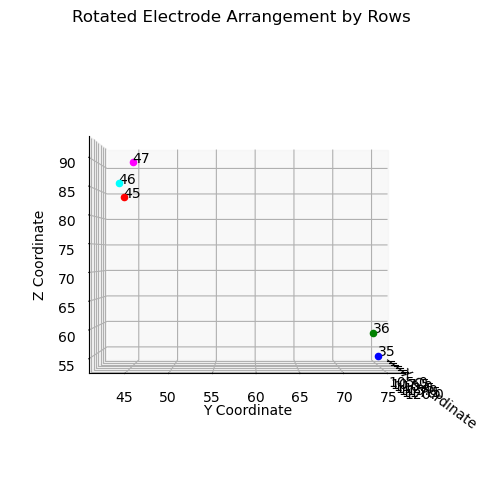

[[35], [36], [45], [46], [47]]


In [99]:
# ep187 sample1 lable2
# Load your data
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep187/ep187_rois_kmeans.csv")

# Create a dictionary to map electrode numbers to positions
electrode_position_map = dict(zip(electrode_df["electrode_number"], electrode_df["position"].apply(ast.literal_eval)))

# Filter electrodes based on the label (e.g., label==3) and get their positions
label_value = 2
label_filtered_arr = []
electrode_label_filtered_df = electrode_df[electrode_df["label"] == label_value]
for index, row in electrode_label_filtered_df.iterrows():
    electrode_number = row["electrode_number"]
    if electrode_number in electrode_position_map:
        label_filtered_arr.append(electrode_position_map[electrode_number])

# Rotate the positions
theta = -20
positions = np.array(label_filtered_arr)
rotated_positions = np.dot(positions, rotation_matrix_x(theta).T)

# Sort rotated positions and find corresponding electrode numbers
z_threshold = 2
rows_electrode_numbers = []
current_row_electrode_numbers = []
last_z = rotated_positions[0, 2]

for position in rotated_positions:
    # Check the electrode number for each rotated position
    electrode_number = next((num for num, pos in electrode_position_map.items() if np.allclose(pos[0], position[0])), None)
    if abs(position[2] - last_z) > z_threshold:
        rows_electrode_numbers.append(current_row_electrode_numbers)
        current_row_electrode_numbers = []  
    if electrode_number is not None:
        current_row_electrode_numbers.append(electrode_number)
    last_z = position[2]

rows_electrode_numbers.append(current_row_electrode_numbers)

# Export the result as a list of lists
result_list = [row for row in rows_electrode_numbers]

# Visualizing the result
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
color_cycle = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow'])

# Plot each point in rows
for row_index, row in enumerate(rows_electrode_numbers):
    current_color = next(color_cycle)
    for col_index, electrode_number in enumerate(row):
        # Find the position of this electrode number
        position = electrode_position_map[electrode_number]
        # Plot the electrode
        ax.scatter(*position, color=current_color)
        # Annotate the plot with the electrode number
        ax.text(*position, f'{electrode_number}')
        
ax.view_init(elev=0, azim=0)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('Rotated Electrode Arrangement by Rows')
plt.show()

# Export the result as a JSON file
with open('ep187_patch2.json', 'w') as f:
    json.dump(result_list, f)

# Print the result
print(result_list)



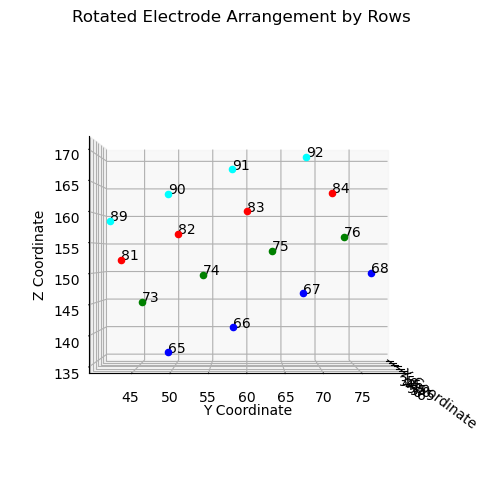

[[65, 66, 67, 68], [73, 74, 75, 76], [81, 82, 83, 84], [89, 90, 91, 92]]


In [103]:
# ep187 sample1 lable3
# Load your data
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep187/ep187_rois_kmeans.csv")

# Create a dictionary to map electrode numbers to positions
electrode_position_map = dict(zip(electrode_df["electrode_number"], electrode_df["position"].apply(ast.literal_eval)))

# Filter electrodes based on the label (e.g., label==3) and get their positions
label_value = 3
label_filtered_arr = []
electrode_label_filtered_df = electrode_df[electrode_df["label"] == label_value]
for index, row in electrode_label_filtered_df.iterrows():
    electrode_number = row["electrode_number"]
    if electrode_number in electrode_position_map:
        label_filtered_arr.append(electrode_position_map[electrode_number])

# Rotate the positions
theta = -20
positions = np.array(label_filtered_arr)
rotated_positions = np.dot(positions, rotation_matrix_x(theta).T)

# Sort rotated positions and find corresponding electrode numbers
z_threshold = 3
rows_electrode_numbers = []
current_row_electrode_numbers = []
last_z = rotated_positions[0, 2]

for position in rotated_positions:
    # Check the electrode number for each rotated position
    electrode_number = next((num for num, pos in electrode_position_map.items() if np.allclose(pos[0], position[0])), None)
    if abs(position[2] - last_z) > z_threshold:
        rows_electrode_numbers.append(current_row_electrode_numbers)
        current_row_electrode_numbers = []  
    if electrode_number is not None:
        current_row_electrode_numbers.append(electrode_number)
    last_z = position[2]

rows_electrode_numbers.append(current_row_electrode_numbers)

# Export the result as a list of lists
result_list = [row for row in rows_electrode_numbers]

# Visualizing the result
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
color_cycle = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow'])

# Plot each point in rows
for row_index, row in enumerate(rows_electrode_numbers):
    current_color = next(color_cycle)
    for col_index, electrode_number in enumerate(row):
        # Find the position of this electrode number
        position = electrode_position_map[electrode_number]
        # Plot the electrode
        ax.scatter(*position, color=current_color)
        # Annotate the plot with the electrode number
        ax.text(*position, f'{electrode_number}')
        
ax.view_init(elev=0, azim=0)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('Rotated Electrode Arrangement by Rows')
plt.show()

# Export the result as a JSON file
with open('ep187_patch3.json', 'w') as f:
    json.dump(result_list, f)

# Print the result
print(result_list)



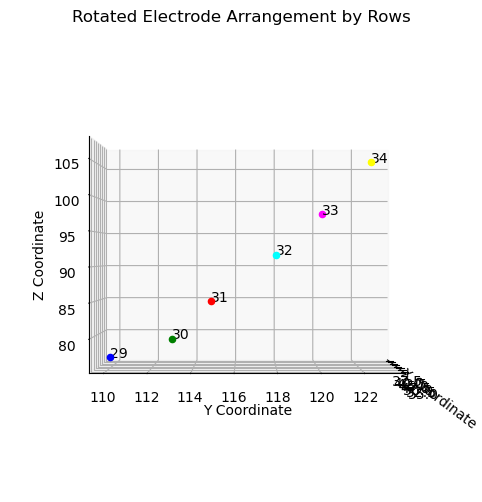

[[29], [30], [31], [32], [33], [34]]


In [112]:
# ep187 sample1 lable4
# Load your data
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep187/ep187_rois_kmeans.csv")

# Create a dictionary to map electrode numbers to positions
electrode_position_map = dict(zip(electrode_df["electrode_number"], electrode_df["position"].apply(ast.literal_eval)))

# Filter electrodes based on the label (e.g., label==3) and get their positions
label_value = 4
label_filtered_arr = []
electrode_label_filtered_df = electrode_df[electrode_df["label"] == label_value]
for index, row in electrode_label_filtered_df.iterrows():
    electrode_number = row["electrode_number"]
    if electrode_number in electrode_position_map:
        label_filtered_arr.append(electrode_position_map[electrode_number])

# Rotate the positions
theta = -20
positions = np.array(label_filtered_arr)
rotated_positions = np.dot(positions, rotation_matrix_x(theta).T)

# Sort rotated positions and find corresponding electrode numbers
z_threshold = 0.5
rows_electrode_numbers = []
current_row_electrode_numbers = []
last_z = rotated_positions[0, 2]

for position in rotated_positions:
    # Check the electrode number for each rotated position
    electrode_number = next((num for num, pos in electrode_position_map.items() if np.allclose(pos[0], position[0])), None)
    if abs(position[2] - last_z) > z_threshold:
        rows_electrode_numbers.append(current_row_electrode_numbers)
        current_row_electrode_numbers = []  
    if electrode_number is not None:
        current_row_electrode_numbers.append(electrode_number)
    last_z = position[2]

rows_electrode_numbers.append(current_row_electrode_numbers)

# Export the result as a list of lists
result_list = [row for row in rows_electrode_numbers]

# Visualizing the result
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
color_cycle = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow'])

# Plot each point in rows
for row_index, row in enumerate(rows_electrode_numbers):
    current_color = next(color_cycle)
    for col_index, electrode_number in enumerate(row):
        # Find the position of this electrode number
        position = electrode_position_map[electrode_number]
        # Plot the electrode
        ax.scatter(*position, color=current_color)
        # Annotate the plot with the electrode number
        ax.text(*position, f'{electrode_number}')
        
ax.view_init(elev=0, azim=0)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('Rotated Electrode Arrangement by Rows')
plt.show()

# Export the result as a JSON file
with open('ep187_patch4.json', 'w') as f:
    json.dump(result_list, f)

# Print the result
print(result_list)



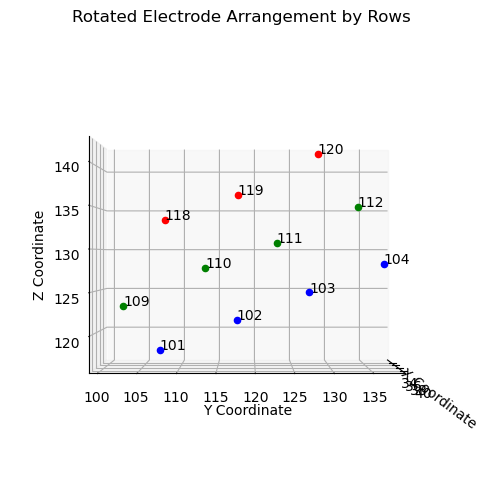

[[101, 102, 103, 104], [109, 110, 111, 112], [118, 119, 120]]


In [143]:
# ep187 sample1 lable5
# Load your data
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep187/ep187_rois_kmeans.csv")

# Create a dictionary to map electrode numbers to positions
electrode_position_map = dict(zip(electrode_df["electrode_number"], electrode_df["position"].apply(ast.literal_eval)))

# Filter electrodes based on the label (e.g., label==3) and get their positions
label_value = 5
label_filtered_arr = []
electrode_label_filtered_df = electrode_df[electrode_df["label"] == label_value]
for index, row in electrode_label_filtered_df.iterrows():
    electrode_number = row["electrode_number"]
    if electrode_number in electrode_position_map:
        label_filtered_arr.append(electrode_position_map[electrode_number])

# Rotate the positions
theta = -30
positions = np.array(label_filtered_arr)
rotated_positions = np.dot(positions, rotation_matrix_x(theta).T)

# Sort rotated positions and find corresponding electrode numbers
z_threshold = 3
rows_electrode_numbers = []
current_row_electrode_numbers = []
last_z = rotated_positions[0, 2]

for position in rotated_positions:
    # Check the electrode number for each rotated position
    electrode_number = next((num for num, pos in electrode_position_map.items() if np.allclose(pos[0], position[0])), None)
    if abs(position[2] - last_z) > z_threshold:
        rows_electrode_numbers.append(current_row_electrode_numbers)
        current_row_electrode_numbers = []  
    if electrode_number is not None:
        current_row_electrode_numbers.append(electrode_number)
    last_z = position[2]

rows_electrode_numbers.append(current_row_electrode_numbers)

# Export the result as a list of lists
result_list = [row for row in rows_electrode_numbers]

# Visualizing the result
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
color_cycle = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow'])

# Plot each point in rows
for row_index, row in enumerate(rows_electrode_numbers):
    current_color = next(color_cycle)
    for col_index, electrode_number in enumerate(row):
        # Find the position of this electrode number
        position = electrode_position_map[electrode_number]
        # Plot the electrode
        ax.scatter(*position, color=current_color)
        # Annotate the plot with the electrode number
        ax.text(*position, f'{electrode_number}')
        
ax.view_init(elev=0, azim=0)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('Rotated Electrode Arrangement by Rows')
plt.show()

# Export the result as a JSON file
with open('ep187_patch5.json', 'w') as f:
    json.dump(result_list, f)

# Print the result
print(result_list)



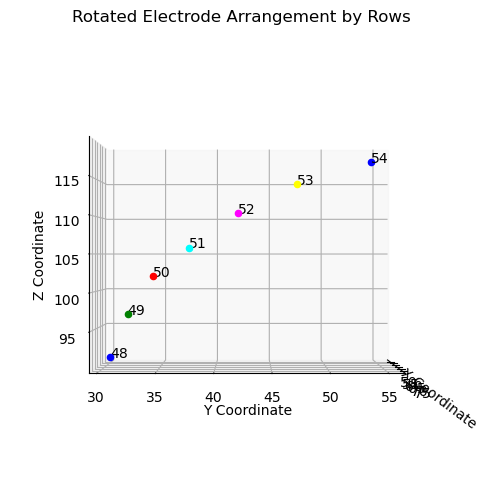

[[48], [49], [50], [51], [52], [53], [54]]


In [124]:
# ep187 sample1 lable6
# Load your data
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep187/ep187_rois_kmeans.csv")

# Create a dictionary to map electrode numbers to positions
electrode_position_map = dict(zip(electrode_df["electrode_number"], electrode_df["position"].apply(ast.literal_eval)))

# Filter electrodes based on the label (e.g., label==3) and get their positions
label_value = 6
label_filtered_arr = []
electrode_label_filtered_df = electrode_df[electrode_df["label"] == label_value]
for index, row in electrode_label_filtered_df.iterrows():
    electrode_number = row["electrode_number"]
    if electrode_number in electrode_position_map:
        label_filtered_arr.append(electrode_position_map[electrode_number])

# Rotate the positions
theta = -30
positions = np.array(label_filtered_arr)
rotated_positions = np.dot(positions, rotation_matrix_x(theta).T)

# Sort rotated positions and find corresponding electrode numbers
z_threshold = 0.5
rows_electrode_numbers = []
current_row_electrode_numbers = []
last_z = rotated_positions[0, 2]

for position in rotated_positions:
    # Check the electrode number for each rotated position
    electrode_number = next((num for num, pos in electrode_position_map.items() if np.allclose(pos[0], position[0])), None)
    if abs(position[2] - last_z) > z_threshold:
        rows_electrode_numbers.append(current_row_electrode_numbers)
        current_row_electrode_numbers = []  
    if electrode_number is not None:
        current_row_electrode_numbers.append(electrode_number)
    last_z = position[2]

rows_electrode_numbers.append(current_row_electrode_numbers)

# Export the result as a list of lists
result_list = [row for row in rows_electrode_numbers]

# Visualizing the result
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
color_cycle = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow'])

# Plot each point in rows
for row_index, row in enumerate(rows_electrode_numbers):
    current_color = next(color_cycle)
    for col_index, electrode_number in enumerate(row):
        # Find the position of this electrode number
        position = electrode_position_map[electrode_number]
        # Plot the electrode
        ax.scatter(*position, color=current_color)
        # Annotate the plot with the electrode number
        ax.text(*position, f'{electrode_number}')
        
ax.view_init(elev=0, azim=0)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('Rotated Electrode Arrangement by Rows')
plt.show()

# Export the result as a JSON file
with open('ep187_patch6.json', 'w') as f:
    json.dump(result_list, f)

# Print the result
print(result_list)



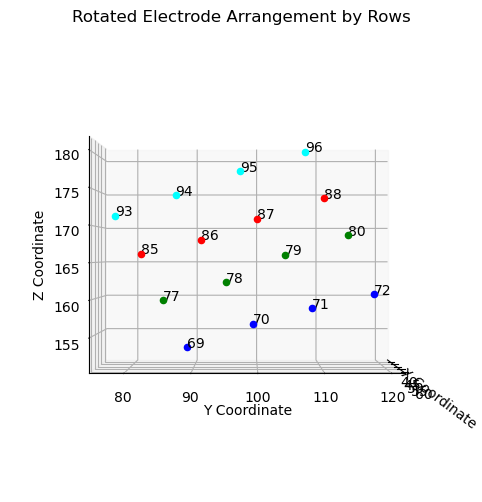

[[69, 70, 71, 72], [77, 78, 79, 80], [85, 86, 87, 88], [93, 94, 95, 96]]


In [140]:
# ep187 sample1 lable7
# Load your data
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep187/ep187_rois_kmeans.csv")

# Create a dictionary to map electrode numbers to positions
electrode_position_map = dict(zip(electrode_df["electrode_number"], electrode_df["position"].apply(ast.literal_eval)))

# Filter electrodes based on the label (e.g., label==3) and get their positions
label_value = 7
label_filtered_arr = []
electrode_label_filtered_df = electrode_df[electrode_df["label"] == label_value]
for index, row in electrode_label_filtered_df.iterrows():
    electrode_number = row["electrode_number"]
    if electrode_number in electrode_position_map:
        label_filtered_arr.append(electrode_position_map[electrode_number])

# Rotate the positions
theta = -20
positions = np.array(label_filtered_arr)
rotated_positions = np.dot(positions, rotation_matrix_x(theta).T)

# Sort rotated positions and find corresponding electrode numbers
z_threshold = 4
rows_electrode_numbers = []
current_row_electrode_numbers = []
last_z = rotated_positions[0, 2]

for position in rotated_positions:
    # Check the electrode number for each rotated position
    electrode_number = next((num for num, pos in electrode_position_map.items() if np.allclose(pos[0], position[0])), None)
    if abs(position[2] - last_z) > z_threshold:
        rows_electrode_numbers.append(current_row_electrode_numbers)
        current_row_electrode_numbers = []  
    if electrode_number is not None:
        current_row_electrode_numbers.append(electrode_number)
    last_z = position[2]

rows_electrode_numbers.append(current_row_electrode_numbers)

# Export the result as a list of lists
result_list = [row for row in rows_electrode_numbers]

# Visualizing the result
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
color_cycle = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow'])

# Plot each point in rows
for row_index, row in enumerate(rows_electrode_numbers):
    current_color = next(color_cycle)
    for col_index, electrode_number in enumerate(row):
        # Find the position of this electrode number
        position = electrode_position_map[electrode_number]
        # Plot the electrode
        ax.scatter(*position, color=current_color)
        # Annotate the plot with the electrode number
        ax.text(*position, f'{electrode_number}')
        
ax.view_init(elev=0, azim=0)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('Rotated Electrode Arrangement by Rows')
plt.show()

# Export the result as a JSON file
with open('ep187_patch7.json', 'w') as f:
    json.dump(result_list, f)

# Print the result
print(result_list)



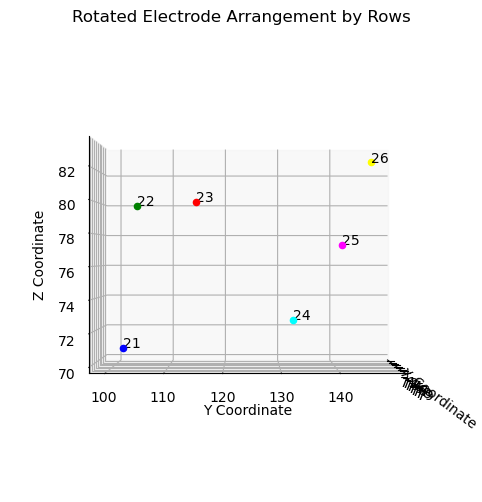

[[21], [22], [23], [24], [25], [26]]


In [180]:
# ep187 sample1 lable8
# Load your data
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep187/ep187_rois_kmeans.csv")

# Create a dictionary to map electrode numbers to positions
electrode_position_map = dict(zip(electrode_df["electrode_number"], electrode_df["position"].apply(ast.literal_eval)))

# Filter electrodes based on the label (e.g., label==3) and get their positions
label_value = 8
label_filtered_arr = []
electrode_label_filtered_df = electrode_df[electrode_df["label"] == label_value]
for index, row in electrode_label_filtered_df.iterrows():
    electrode_number = row["electrode_number"]
    if electrode_number in electrode_position_map:
        label_filtered_arr.append(electrode_position_map[electrode_number])

# Rotate the positions
theta = 20
positions = np.array(label_filtered_arr)
rotated_positions = np.dot(positions, rotation_matrix_x(theta).T)

# Sort rotated positions and find corresponding electrode numbers
z_threshold = 1
rows_electrode_numbers = []
current_row_electrode_numbers = []
last_z = rotated_positions[0, 2]

for position in rotated_positions:
    # Check the electrode number for each rotated position
    electrode_number = next((num for num, pos in electrode_position_map.items() if np.allclose(pos[0], position[0])), None)
    if abs(position[2] - last_z) > z_threshold:
        rows_electrode_numbers.append(current_row_electrode_numbers)
        current_row_electrode_numbers = []  
    if electrode_number is not None:
        current_row_electrode_numbers.append(electrode_number)
    last_z = position[2]

rows_electrode_numbers.append(current_row_electrode_numbers)

# Export the result as a list of lists
result_list = [row for row in rows_electrode_numbers]

# Visualizing the result
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
color_cycle = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow'])

# Plot each point in rows
for row_index, row in enumerate(rows_electrode_numbers):
    current_color = next(color_cycle)
    for col_index, electrode_number in enumerate(row):
        # Find the position of this electrode number
        position = electrode_position_map[electrode_number]
        # Plot the electrode
        ax.scatter(*position, color=current_color)
        # Annotate the plot with the electrode number
        ax.text(*position, f'{electrode_number}')
        
ax.view_init(elev=0, azim=0)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('Rotated Electrode Arrangement by Rows')
plt.show()

# Export the result as a JSON file
# with open('ep187_patch8.json', 'w') as f:
#     json.dump(result_list, f)

# Print the result
print(result_list)



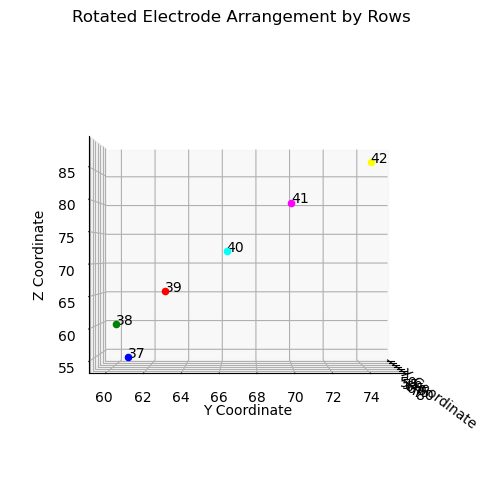

[[37], [38], [39], [40], [41], [42]]


In [181]:
# ep187 sample1 lable9
# Load your data
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep187/ep187_rois_kmeans.csv")

# Create a dictionary to map electrode numbers to positions
electrode_position_map = dict(zip(electrode_df["electrode_number"], electrode_df["position"].apply(ast.literal_eval)))

# Filter electrodes based on the label (e.g., label==3) and get their positions
label_value = 9
label_filtered_arr = []
electrode_label_filtered_df = electrode_df[electrode_df["label"] == label_value]
for index, row in electrode_label_filtered_df.iterrows():
    electrode_number = row["electrode_number"]
    if electrode_number in electrode_position_map:
        label_filtered_arr.append(electrode_position_map[electrode_number])

# Rotate the positions
theta = 20
positions = np.array(label_filtered_arr)
rotated_positions = np.dot(positions, rotation_matrix_x(theta).T)

# Sort rotated positions and find corresponding electrode numbers
z_threshold = 1
rows_electrode_numbers = []
current_row_electrode_numbers = []
last_z = rotated_positions[0, 2]

for position in rotated_positions:
    # Check the electrode number for each rotated position
    electrode_number = next((num for num, pos in electrode_position_map.items() if np.allclose(pos[0], position[0])), None)
    if abs(position[2] - last_z) > z_threshold:
        rows_electrode_numbers.append(current_row_electrode_numbers)
        current_row_electrode_numbers = []  
    if electrode_number is not None:
        current_row_electrode_numbers.append(electrode_number)
    last_z = position[2]

rows_electrode_numbers.append(current_row_electrode_numbers)

# Export the result as a list of lists
result_list = [row for row in rows_electrode_numbers]

# Visualizing the result
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
color_cycle = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow'])

# Plot each point in rows
for row_index, row in enumerate(rows_electrode_numbers):
    current_color = next(color_cycle)
    for col_index, electrode_number in enumerate(row):
        # Find the position of this electrode number
        position = electrode_position_map[electrode_number]
        # Plot the electrode
        ax.scatter(*position, color=current_color)
        # Annotate the plot with the electrode number
        ax.text(*position, f'{electrode_number}')
        
ax.view_init(elev=0, azim=0)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('Rotated Electrode Arrangement by Rows')
plt.show()

# Export the result as a JSON file
# with open('ep187_patch9.json', 'w') as f:
#     json.dump(result_list, f)

# Print the result
print(result_list)



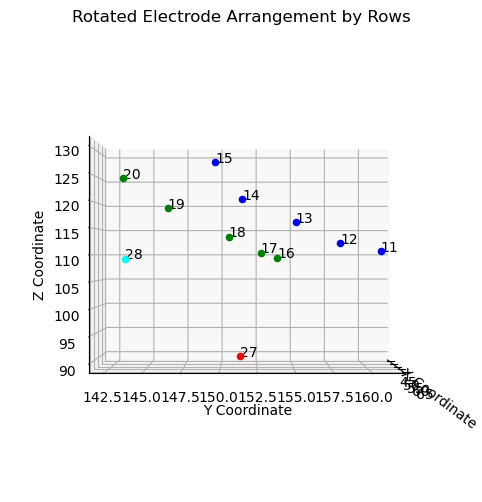

[[11, 12, 13, 14, 15], [16, 17, 18, 19, 20], [27], [28]]


In [182]:
# ep187 sample1 lable10
# Load your data
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep187/ep187_rois_kmeans.csv")

# Create a dictionary to map electrode numbers to positions
electrode_position_map = dict(zip(electrode_df["electrode_number"], electrode_df["position"].apply(ast.literal_eval)))

# Filter electrodes based on the label (e.g., label==3) and get their positions
label_value = 10
label_filtered_arr = []
electrode_label_filtered_df = electrode_df[electrode_df["label"] == label_value]
for index, row in electrode_label_filtered_df.iterrows():
    electrode_number = row["electrode_number"]
    if electrode_number in electrode_position_map:
        label_filtered_arr.append(electrode_position_map[electrode_number])

# Rotate the positions
theta = 50
positions = np.array(label_filtered_arr)
rotated_positions = np.dot(positions, rotation_matrix_x(theta).T)

# Sort rotated positions and find corresponding electrode numbers
z_threshold = 4
rows_electrode_numbers = []
current_row_electrode_numbers = []
last_z = rotated_positions[0, 2]

for position in rotated_positions:
    # Check the electrode number for each rotated position
    electrode_number = next((num for num, pos in electrode_position_map.items() if np.allclose(pos[0], position[0])), None)
    if abs(position[2] - last_z) > z_threshold:
        rows_electrode_numbers.append(current_row_electrode_numbers)
        current_row_electrode_numbers = []  
    if electrode_number is not None:
        current_row_electrode_numbers.append(electrode_number)
    last_z = position[2]

rows_electrode_numbers.append(current_row_electrode_numbers)

# Export the result as a list of lists
result_list = [row for row in rows_electrode_numbers]

# Visualizing the result
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
color_cycle = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow'])

# Plot each point in rows
for row_index, row in enumerate(rows_electrode_numbers):
    current_color = next(color_cycle)
    for col_index, electrode_number in enumerate(row):
        # Find the position of this electrode number
        position = electrode_position_map[electrode_number]
        # Plot the electrode
        ax.scatter(*position, color=current_color)
        # Annotate the plot with the electrode number
        ax.text(*position, f'{electrode_number}')
        
ax.view_init(elev=0, azim=0)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('Rotated Electrode Arrangement by Rows')
plt.show()

# Export the result as a JSON file
# with open('ep187_patch10.json', 'w') as f:
#     json.dump(result_list, f)

# Print the result
print(result_list)



In [175]:
# combine ep187 sample 1 data
data_list = []

# Load data from each JSON file and append it to the list
for i in range(1, 11):
    filename = f"ep187_patch{i}.json"  
    with open(filename, "r") as file:
        data = json.load(file)
        data_list.append(data)

combined_data = {str(i): data_list[i - 1] for i in range(1, 11)}

# Write the combined data to a new JSON file
with open("ep187_patch_data.json", "w") as outfile:
    json.dump(combined_data, outfile)

print("Data has been combined and saved to 'combined_data.json'")


Data has been combined and saved to 'combined_data.json'


In [177]:
# combine ep129 sample 1 data
data_list = []

# Load data from each JSON file and append it to the list
for i in range(3):
    filename = f"roi{i}_electrodes.json"  
    with open(filename, "r") as file:
        data = json.load(file)
        data_list.append(data)

combined_data = {str(i): data_list[i] for i in range(3)}

# Write the combined data to a new JSON file
with open("ep129_patch_data.json", "w") as outfile:
    json.dump(combined_data, outfile)

print("Data has been combined and saved to 'combined_data.json'")

Data has been combined and saved to 'combined_data.json'


In [178]:
propagation_df = pd.read_json("/Users/siyuanzhao/Downloads/ep187_sample1_events.json")

electrode_counts = {}

for network_list in propagation_df['network']:
    if(network_list):
        for item in network_list:
            source = item['source']
            target = item['target']

            # Increment source count
            if source in electrode_counts:
                electrode_counts[source]['source_counts'] += 1
            else:
                electrode_counts[source] = {'electrode_id': source, 'source_counts': 1, 'target_counts': 0}

            # Increment target count
            if target in electrode_counts:
                electrode_counts[target]['target_counts'] += 1
            else:
                electrode_counts[target] = {'electrode_id': target, 'source_counts': 0, 'target_counts': 1}

# Convert 
result = list(electrode_counts.values())

print(result)

output_file = 'ep187_sample1_propagation_new.json'
with open(output_file, 'w') as file:
    json.dump(result, file, indent=4)

[{'electrode_id': 92, 'source_counts': 601, 'target_counts': 488}, {'electrode_id': 84, 'source_counts': 532, 'target_counts': 460}, {'electrode_id': 116, 'source_counts': 93, 'target_counts': 64}, {'electrode_id': 39, 'source_counts': 102, 'target_counts': 139}, {'electrode_id': 76, 'source_counts': 125, 'target_counts': 131}, {'electrode_id': 72, 'source_counts': 543, 'target_counts': 531}, {'electrode_id': 81, 'source_counts': 336, 'target_counts': 499}, {'electrode_id': 70, 'source_counts': 580, 'target_counts': 524}, {'electrode_id': 89, 'source_counts': 200, 'target_counts': 217}, {'electrode_id': 78, 'source_counts': 471, 'target_counts': 391}, {'electrode_id': 13, 'source_counts': 68, 'target_counts': 102}, {'electrode_id': 71, 'source_counts': 311, 'target_counts': 395}, {'electrode_id': 87, 'source_counts': 251, 'target_counts': 226}, {'electrode_id': 79, 'source_counts': 450, 'target_counts': 421}, {'electrode_id': 80, 'source_counts': 259, 'target_counts': 267}, {'electrode